In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

In [53]:
df = pd.read_csv ('./SDD.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [55]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [56]:
def drop_low_high_variance_cols(df, low_thresh=1.0, high_thresh=99.0):
    """
    Xóa các cột object/number nếu:
    - Tỷ lệ giá trị phổ biến nhất < low_thresh (%)
    - Hoặc tỷ lệ giá trị phổ biến nhất > high_thresh (%)
    """
    cols_to_drop = []

    for col in df.columns:
        counts = df[col].value_counts(normalize=True) * 100
        if len(counts) == 0:
            continue
        top_percent = counts.iloc[0]

        if top_percent < low_thresh or top_percent > high_thresh:
            cols_to_drop.append(col)

    print("Các cột sẽ bị loại bỏ:", cols_to_drop)
    return df.drop(columns=cols_to_drop)

# Áp dụng cho dataset
df = drop_low_high_variance_cols(df, low_thresh=1, high_thresh=99)
df = df.drop(columns="City")
# Kiểm tra lại
print(df.info())

Các cột sẽ bị loại bỏ: ['id', 'Profession', 'Work Pressure', 'Job Satisfaction']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   Academic Pressure                      27901 non-null  float64
 3   CGPA                                   27901 non-null  float64
 4   Study Satisfaction                     27901 non-null  float64
 5   Sleep Duration                         27901 non-null  object 
 6   Dietary Habits                         27901 non-null  object 
 7   Degree                                 27901 non-null  object 
 8   Have you ever had suicidal thoughts ?  27901 non-null  object 
 9   Work/Study Hours                       27901 non-null  fl

In [57]:
def drop_rare_values(df, threshold=0.05):
    """
    Loại bỏ các dòng chứa giá trị hiếm (< threshold %)
    Áp dụng cho tất cả các cột (object, numeric, category, ...)
    """
    df = df.copy()
    n_rows = len(df)

    for col in df.columns:
        value_counts = df[col].value_counts(normalize=True) * 100
        rare_values = value_counts[value_counts < threshold].index
        if len(rare_values) > 0:
            df = df.loc[~df[col].isin(rare_values)].copy()
            # Chuyển kiểu sang category nếu là object
            if df[col].dtype == "object":
                df[col] = df[col].astype("category")

    print(f"Số dòng ban đầu: {n_rows}")
    print(f"Số dòng sau khi lọc: {len(df)}")
    print(f"Số dòng bị loại bỏ: {n_rows - len(df)}")
    return df
df = drop_rare_values(df, threshold=0.05)

Số dòng ban đầu: 27901
Số dòng sau khi lọc: 27785
Số dòng bị loại bỏ: 116


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27785 entries, 0 to 27900
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Gender                                 27785 non-null  object  
 1   Age                                    27785 non-null  float64 
 2   Academic Pressure                      27785 non-null  float64 
 3   CGPA                                   27785 non-null  float64 
 4   Study Satisfaction                     27785 non-null  float64 
 5   Sleep Duration                         27785 non-null  object  
 6   Dietary Habits                         27785 non-null  category
 7   Degree                                 27785 non-null  object  
 8   Have you ever had suicidal thoughts ?  27785 non-null  object  
 9   Work/Study Hours                       27785 non-null  float64 
 10  Financial Stress                       27785 non-null  category

In [59]:
binary_maps = {
    "Gender": {"Male": 0, "Female": 1},
    "Have you ever had suicidal thoughts ?": {"No": 0, "Yes": 1},
    "Family History of Mental Illness": {"No": 0, "Yes": 1}
}
for col, mapping in binary_maps.items():
    df[col] = df[col].map(mapping)

In [60]:
def group_degree(df, column="Degree"):
    """
    Gom nhóm Degree thành 2 nhóm:
    - Class 12
    - Higher Degree
    """
    df[column] = df[column].apply(lambda x: "'Class 12'" if x == "'Class 12'" else "Higher Degree")
    return df
df = group_degree(df)

In [61]:
print("Unique values in 'Sleep Duration':", df['Sleep Duration'].unique())

Unique values in 'Sleep Duration': ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']


In [62]:
sleep_encode = {
    "'Less than 5 hours'": 1,
    "'5-6 hours'": 2,
    "'7-8 hours'": 3,
    "'More than 8 hours'": 4,
    "Others": 0
}

df["Sleep Duration"] = df["Sleep Duration"].map(sleep_encode)

In [63]:
nominal_cols = ["Dietary Habits", "Degree"]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=False)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27785 entries, 0 to 27900
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Gender                                 27785 non-null  int64   
 1   Age                                    27785 non-null  float64 
 2   Academic Pressure                      27785 non-null  float64 
 3   CGPA                                   27785 non-null  float64 
 4   Study Satisfaction                     27785 non-null  float64 
 5   Sleep Duration                         27785 non-null  int64   
 6   Have you ever had suicidal thoughts ?  27785 non-null  int64   
 7   Work/Study Hours                       27785 non-null  float64 
 8   Financial Stress                       27785 non-null  category
 9   Family History of Mental Illness       27785 non-null  int64   
 10  Depression                             27785 non-null  int64   

In [65]:
df["Financial Stress"] = df["Financial Stress"].astype('Float64').astype('Int64')
ordinal_map = {
    "Financial Stress": [1, 2, 3, 4, 5],
}
for col, order in ordinal_map.items():
    if df[col].dtype.name == "category":
        df[col] = df[col].cat.set_categories(order, ordered=True).codes + 1

In [66]:
def convert_float_to_int(df):
    """
    Tự động chuyển các cột float thành int nếu toàn bộ giá trị là số nguyên.
    """
    for col in df.select_dtypes(include=["float64"]).columns:
        # Kiểm tra toàn bộ giá trị có phải số nguyên không
        if np.allclose(df[col], df[col].astype(int), equal_nan=True):
            df[col] = df[col].astype("Int64")  # dùng Int64 để hỗ trợ cả NaN
            print(f"Cột '{col}' đã được chuyển từ float -> int")
        else:
            print(f"Cột '{col}' giữ nguyên float (có giá trị thập phân)")
    return df

# Áp dụng cho dataframe
df = convert_float_to_int(df)
df.info()
df.head(10)

Cột 'Age' đã được chuyển từ float -> int
Cột 'Academic Pressure' đã được chuyển từ float -> int
Cột 'CGPA' giữ nguyên float (có giá trị thập phân)
Cột 'Study Satisfaction' đã được chuyển từ float -> int
Cột 'Work/Study Hours' đã được chuyển từ float -> int
<class 'pandas.core.frame.DataFrame'>
Index: 27785 entries, 0 to 27900
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27785 non-null  int64  
 1   Age                                    27785 non-null  Int64  
 2   Academic Pressure                      27785 non-null  Int64  
 3   CGPA                                   27785 non-null  float64
 4   Study Satisfaction                     27785 non-null  Int64  
 5   Sleep Duration                         27785 non-null  int64  
 6   Have you ever had suicidal thoughts ?  27785 non-null  int64  
 7   Work/Study Hours      

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_'Class 12',Degree_Higher Degree
0,0,33,5,8.97,2,2,1,3,1,0,1,True,False,False,False,True
1,1,24,2,5.90,5,2,0,3,2,1,0,False,True,False,False,True
2,0,31,3,7.03,5,1,0,9,1,1,0,True,False,False,False,True
3,1,28,3,5.59,2,3,1,4,5,1,1,False,True,False,False,True
4,1,25,4,8.13,3,2,1,1,1,0,0,False,True,False,False,True
5,0,29,2,5.70,3,1,0,4,1,0,0,True,False,False,False,True
6,0,30,3,9.54,4,3,0,1,2,0,0,True,False,False,False,True
7,1,30,2,8.04,4,1,0,0,1,1,0,False,False,True,True,False
8,0,28,3,9.79,1,3,1,12,3,0,1,False,True,False,False,True
9,0,31,2,8.38,3,1,1,2,5,0,1,False,True,False,False,True


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27785 entries, 0 to 27900
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27785 non-null  int64  
 1   Age                                    27785 non-null  Int64  
 2   Academic Pressure                      27785 non-null  Int64  
 3   CGPA                                   27785 non-null  float64
 4   Study Satisfaction                     27785 non-null  Int64  
 5   Sleep Duration                         27785 non-null  int64  
 6   Have you ever had suicidal thoughts ?  27785 non-null  int64  
 7   Work/Study Hours                       27785 non-null  Int64  
 8   Financial Stress                       27785 non-null  Int64  
 9   Family History of Mental Illness       27785 non-null  int64  
 10  Depression                             27785 non-null  int64  
 11  Dietary

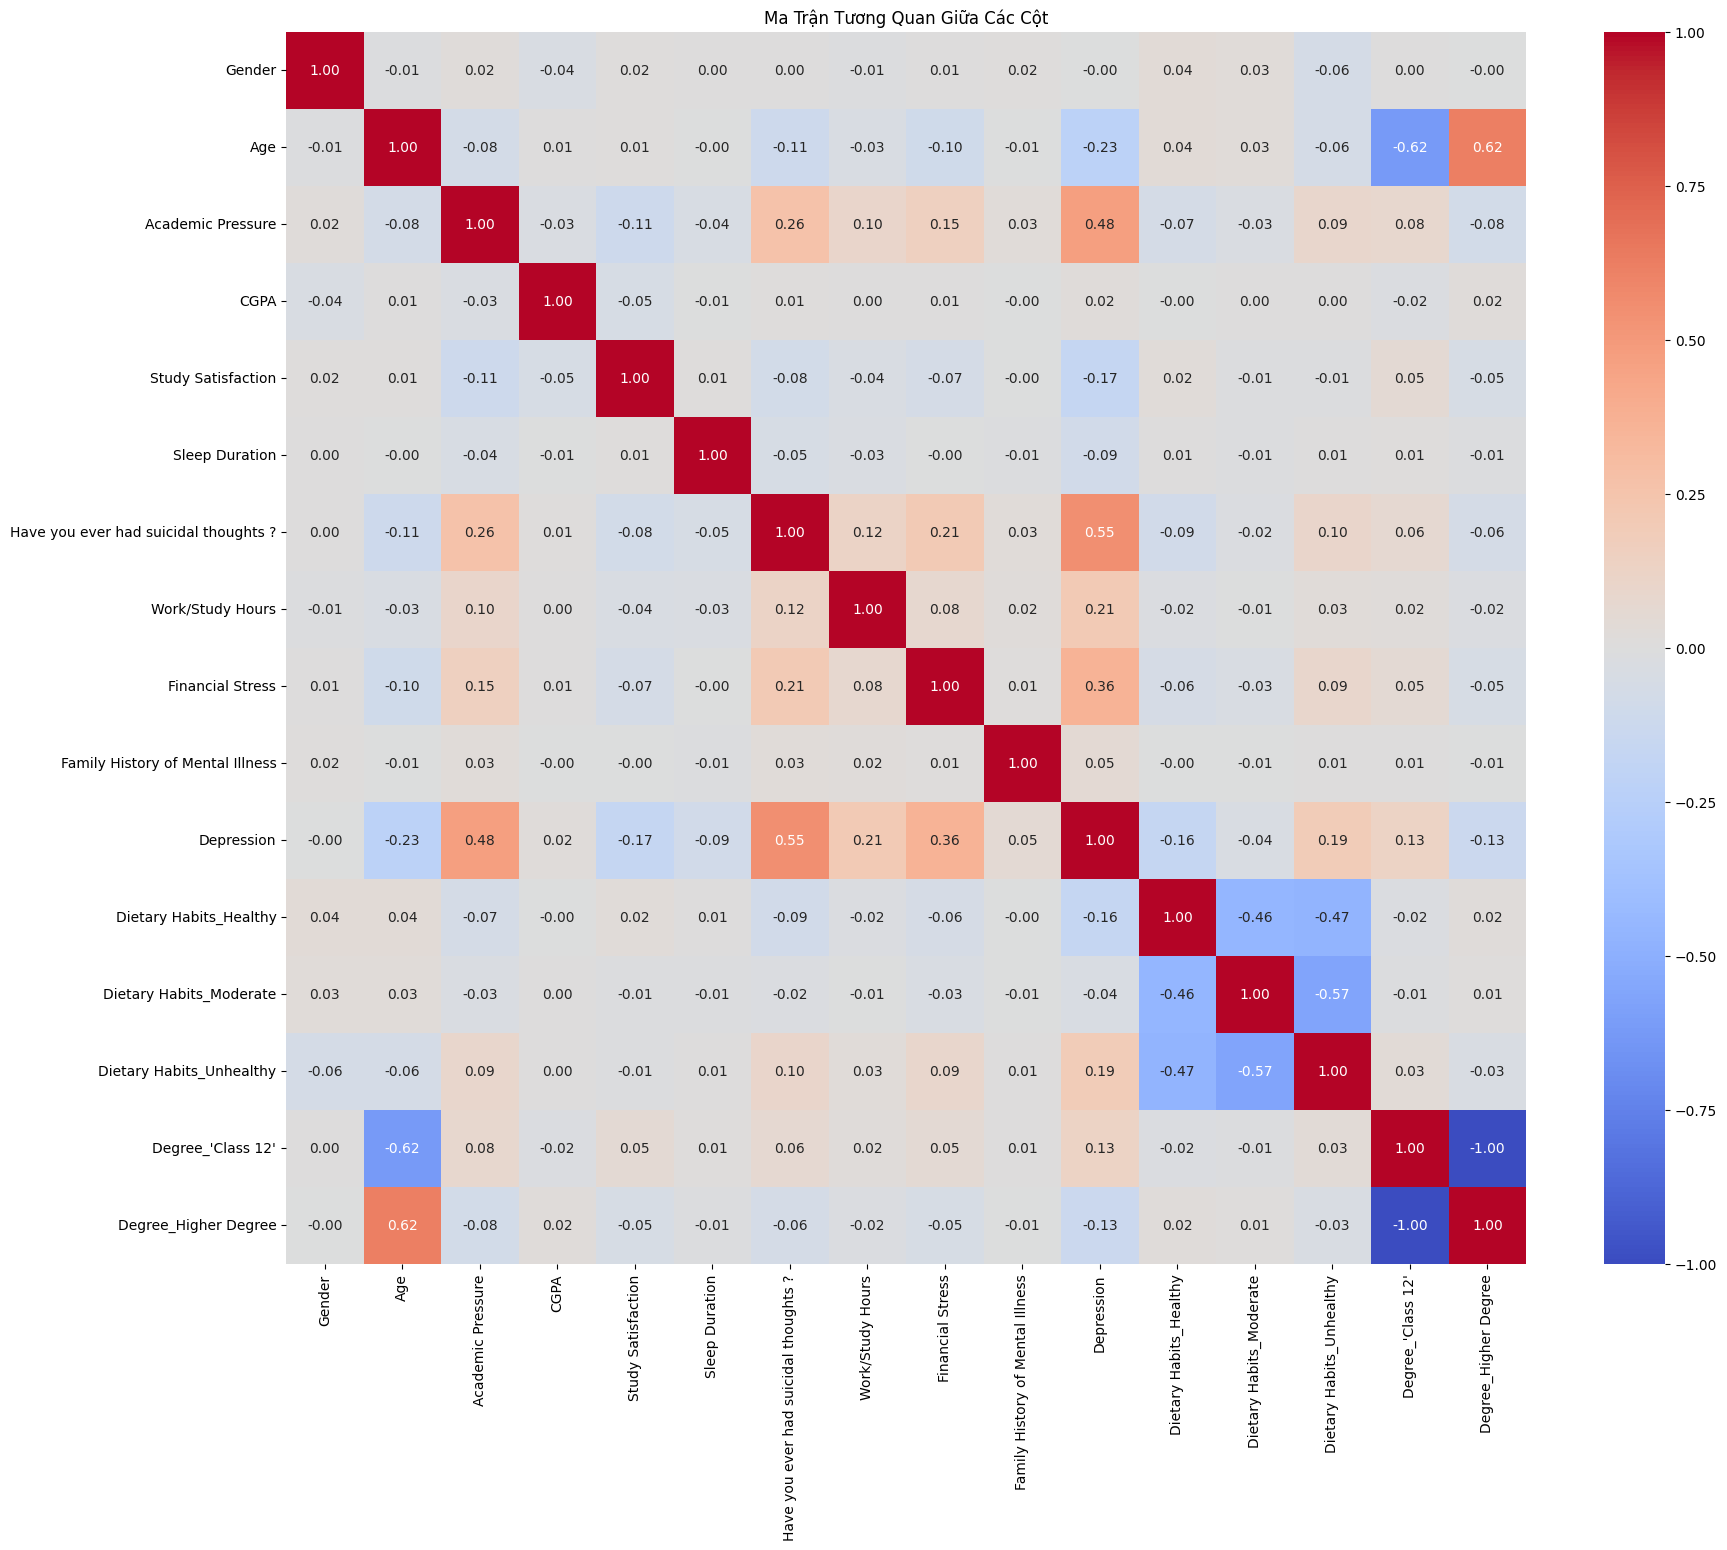

In [68]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Ma Trận Tương Quan Giữa Các Cột")
plt.show()

In [69]:
X = df.drop(columns=["Depression"])   # features
y = df["Depression"]                  # target

mi = mutual_info_classif(X, y, discrete_features='auto')
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print(mi_series.head(30))

Have you ever had suicidal thoughts ?    0.160906
Academic Pressure                        0.123904
Financial Stress                         0.067195
Age                                      0.025933
Work/Study Hours                         0.024093
Study Satisfaction                       0.018243
Dietary Habits_Unhealthy                 0.014475
Dietary Habits_Healthy                   0.013880
Degree_Higher Degree                     0.010018
CGPA                                     0.005645
Degree_'Class 12'                        0.004910
Sleep Duration                           0.004531
Family History of Mental Illness         0.004005
Gender                                   0.002925
Dietary Habits_Moderate                  0.002076
dtype: float64


In [70]:
chi_vals, p_vals = chi2(X, y)
chi2_series = pd.Series(chi_vals, index=X.columns).sort_values(ascending=False)

print(chi2_series.head(20))

Academic Pressure                        3801.394870
Have you ever had suicidal thoughts ?    3050.408853
Financial Stress                         2430.317774
Work/Study Hours                         2311.754618
Age                                      1294.852267
Dietary Habits_Unhealthy                  630.740859
Dietary Habits_Healthy                    546.135388
Study Satisfaction                        496.132320
Degree_'Class 12'                         372.389400
Sleep Duration                            112.086400
Degree_Higher Degree                      103.633763
Family History of Mental Illness           42.297657
Dietary Habits_Moderate                    25.964665
CGPA                                        3.775160
Gender                                      0.036913
dtype: float64


In [71]:
main_features = [
    "Academic Pressure",
    "Have you ever had suicidal thoughts ?",
    "Financial Stress",
    "Work/Study Hours",
    "Age",
    "Dietary Habits_Unhealthy",
    "Dietary Habits_Healthy",
    "Study Satisfaction"
]
secondary_features = [
    "Degree_'Class 12'",
    "Degree_Higher Degree",
    "Sleep Duration"
]
target = "Depression"
X_main = df[main_features]
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_main)
X_all = df[main_features + secondary_features]

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [74]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ANN (MLP)": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    print()

results

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2300
           1       0.85      0.90      0.87      3257

    accuracy                           0.85      5557
   macro avg       0.85      0.84      0.84      5557
weighted avg       0.85      0.85      0.85      5557


=== SVM ===
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      2300
           1       0.85      0.90      0.87      3257

    accuracy                           0.84      5557
   macro avg       0.84      0.83      0.84      5557
weighted avg       0.84      0.84      0.84      5557


=== KNN ===
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2300
           1       0.84      0.88      0.85      3257

    accuracy                           0.83      5557
   macro avg       0.82      0.82      0.82      5557
weighted avg       0

{'Logistic Regression': 0.8472197228720533,
 'SVM': 0.8438006118409214,
 'KNN': 0.8258052906244376,
 'Naive Bayes': 0.8445204246895807,
 'Random Forest': 0.8243656649271189,
 'ANN (MLP)': 0.8393017815368005}

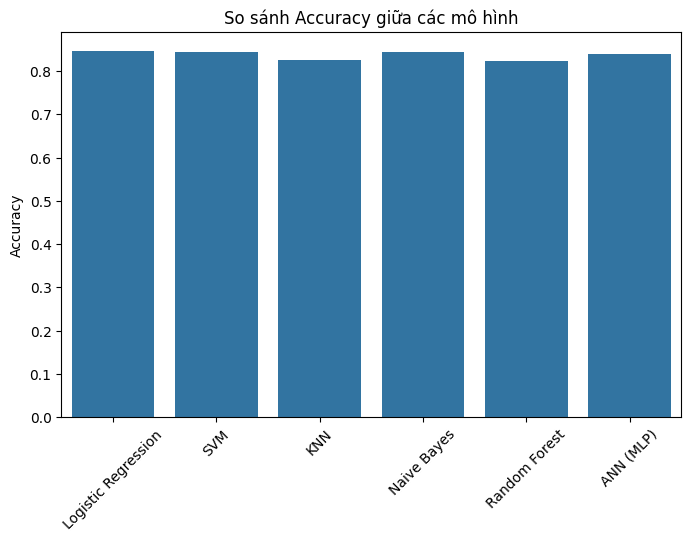

In [75]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("So sánh Accuracy giữa các mô hình")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

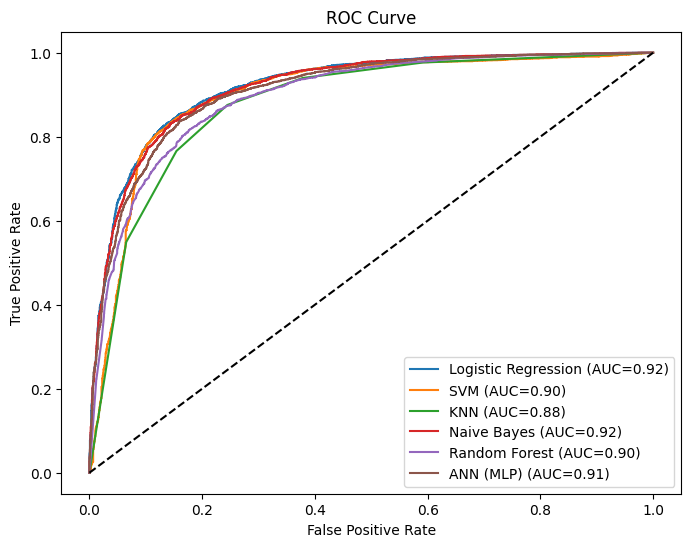

In [78]:
# ROC Curve cho nhiều mô hình
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()